In [7]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        x, (hidden, cell) = self.lstm(x, (h0, c0))
        x = self.fc(x.reshape(x.shape[0], -1))
        
        return x

In [9]:
root_path = "/home/becode/Projects/Bagaar/images/"

train_dataset = datasets.ImageFolder(
    root = os.path.join(root_path, "train"),
    transform = transforms.Compose([
        transforms.Grayscale(), transforms.ToTensor()
    ])
)
test_dataset = datasets.ImageFolder(
    root = os.path.join(root_path, "validation"),
    transform = transforms.Compose([
        transforms.Grayscale(), transforms.ToTensor()
    ])
)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=batch_size)

In [10]:
input_size = 48
sequence_length = 48
hidden_size = 256
num_layers = 2
num_classes = 7
batch_size = 100
learning_rate = 0.001
num_epochs = 20

device = torch.device("cpu")
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load("models/lstm_classifier/lstm_obj_xx.torch")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

LSTM(
  (lstm): LSTM(48, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=12288, out_features=7, bias=True)
)

In [11]:
if True:
    accuracy = []
    for i, (X, y) in enumerate(train_loader):
        predict = model(X.squeeze(1)).reshape(X.shape[0], -1).max(-1)[1]
        accuracy.append((predict==y).sum() / batch_size*100)
    print(sum(accuracy) / len(test_loader), "% accuracy")

tensor(400.1690) % accuracy


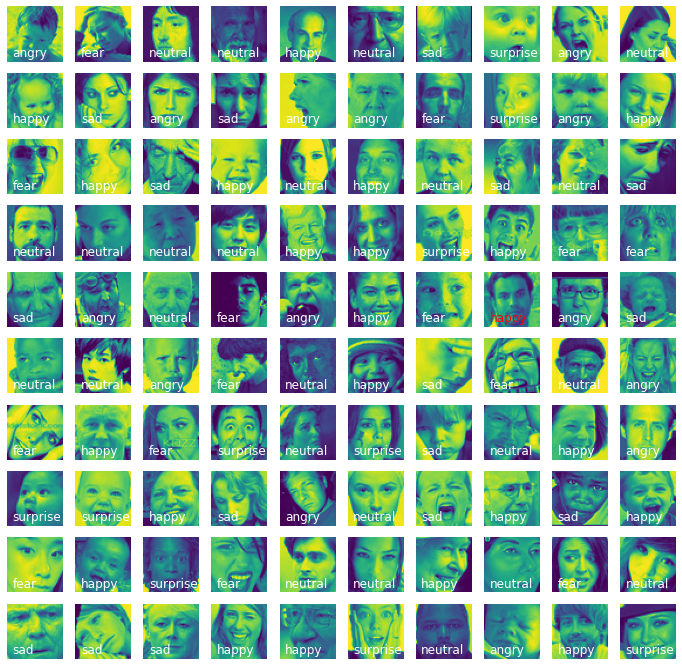

In [12]:
if True:
    X, y = next(iter(train_loader))
    lookup = {i: k for k, i in train_dataset.class_to_idx.items()}
    labels = torch.detach(model(X.squeeze(1)).max(-1)[1]).numpy()
    length = int(len(labels)**.5)
    fig, ax = plt.subplots(length, length, figsize=(12,12))
    for i, axis in enumerate(ax.flatten()):
        axis.set_axis_off()
        axis.imshow(X[i][0])
        axis.text(
            s=lookup[labels[i]],
            transform=axis.transAxes,
            x=.1,y=.1, fontsize=12,
            c="w" if labels[i]==y[i] else "r")

In [25]:
captures = []
cap = cv2.VideoCapture(0)

frame_shape = (480, 640)
box_shape = (192,192)
target_shape = (48, 48)

start_xy = (frame_shape[1]//2 -box_shape[1]//2, frame_shape[0]//2 -box_shape[0]//2)
end_xy = (frame_shape[1]//2 +box_shape[1]//2, frame_shape[0]//2 +box_shape[0]//2)
label_xy = (frame_shape[0] -50, frame_shape[1]//2)

lookup = {i:k for k, i in train_dataset.class_to_idx.items()}

frames = []
for i in range(16):
    frames.append(np.array(cap.read()[1]))
    frames[i] = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    
labels = ["" for i in range(16)]
    
idx = 0
fps = 0
start = time.time()
while True:
    cv2.putText(frames[idx], f"{fps}fps", (50, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, .7, (0,0,255))
    cv2.putText(frames[idx], str(labels[idx]), label_xy, cv2.FONT_HERSHEY_COMPLEX_SMALL, .7, (0,0,255))
    cv2.rectangle(frames[idx], start_xy, end_xy, (255,0,0), 1)
    cv2.imshow("frame", frames[idx])
    
    frames[idx] = np.array(cap.read()[1])
    frames[idx] = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2GRAY)
    
    idx += 1
    if idx == 16:
        fps = int(1/((time.time() -start)/16))
        start = time.time()
        idx = 0
        
        crop = list(map(lambda batch: batch[
            start_xy[1]:end_xy[1], start_xy[0]:end_xy[0]
        ], frames))
        crop = np.array(list(map(lambda batch: cv2.resize(
            batch, target_shape, interpolation=cv2.INTER_CUBIC
        ), crop)))
        
        tensor = torch.Tensor(crop)
        labels = list(map(lambda label: lookup[int(label)], model(tensor).max(-1)[1]))
       
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    if cv2.waitKey(1) & 0xFF == ord('d'):
        caps = frames[idx][
            start_xy[1]:end_xy[1], start_xy[0]:end_xy[0]
        ]
        caps = cv2.resize(
            caps, target_shape, interpolation=cv2.INTER_CUBIC
        )        
        captures.append(caps)

cap.release()
cv2.destroyAllWindows()

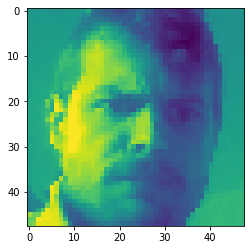

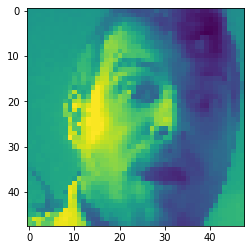

In [32]:
for img in captures:
    plt.imshow(img)
    plt.show()

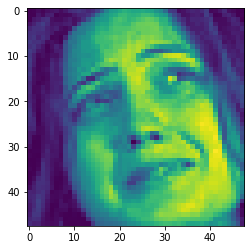

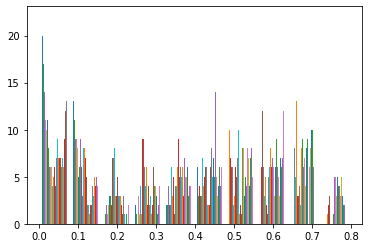

In [17]:
X, _ = next(iter(train_loader))
plt.imshow(X[0][0])
plt.show()

plt.hist(X[0][0])
plt.show()